In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('Rekdat').getOrCreate()

In [ ]:
spark

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
import warnings
warnings.filterwarnings("ignore")

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

os.environ['KAGGLE_CONFIG_DIR']='/content'

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d datasnaek/youtube-new

 93% 187M/201M [00:01<00:00, 146MB/s]
100% 201M/201M [00:01<00:00, 137MB/s]


In [ ]:
!unzip "/content/youtube-new.zip" -d "/content"

Archive:  /content/youtube-new.zip
  inflating: /content/CA_category_id.json  
  inflating: /content/CAvideos.csv   
  inflating: /content/DE_category_id.json  
  inflating: /content/DEvideos.csv   
  inflating: /content/FR_category_id.json  
  inflating: /content/FRvideos.csv   
  inflating: /content/GB_category_id.json  
  inflating: /content/GBvideos.csv   
  inflating: /content/IN_category_id.json  
  inflating: /content/INvideos.csv   
  inflating: /content/JP_category_id.json  
  inflating: /content/JPvideos.csv   
  inflating: /content/KR_category_id.json  
  inflating: /content/KRvideos.csv   
  inflating: /content/MX_category_id.json  
  inflating: /content/MXvideos.csv   
  inflating: /content/RU_category_id.json  
  inflating: /content/RUvideos.csv   
  inflating: /content/US_category_id.json  
  inflating: /content/USvideos.csv   


In [ ]:
schema = StructType([
    StructField("video_id", StringType(), nullable=True),
    StructField("trending_date", StringType(), nullable=True),
    StructField("title", StringType(), nullable=True),
    StructField("channel_title", StringType(), nullable=True),
    StructField("category_id", IntegerType(), nullable=True),
    StructField("publish_time", StringType(), nullable=True),
    StructField("tags", StringType(), nullable=True),
    StructField("views", IntegerType(), nullable=True),
    StructField("likes", IntegerType(), nullable=True),
    StructField("dislikes", IntegerType(), nullable=True),
    StructField("comment_count", IntegerType(), nullable=True),
    StructField("thumbnail_link", StringType(), nullable=True),
    StructField("comments_disabled", BooleanType(), nullable=True),
    StructField("ratings_disabled", BooleanType(), nullable=True),
    StructField("video_error_or_removed", BooleanType(), nullable=True),
    StructField("description", StringType(), nullable=True)]
)

In [ ]:
US_VIDEOS = '/content/USvideos.csv'
df_US = spark.read.option("header","true").csv(path=US_VIDEOS, schema=schema).cache()

In [ ]:
df_US.printSchema()

root
 |-- video_id: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- title: string (nullable = true)
 |-- channel_title: string (nullable = true)
 |-- category_id: integer (nullable = true)
 |-- publish_time: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- views: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- video_error_or_removed: boolean (nullable = true)
 |-- description: string (nullable = true)



In [ ]:
df_US.show(3)

+-----------+-------------+--------------------+---------------+-----------+--------------------+--------------------+-------+------+--------+-------------+--------------------+-----------------+----------------+----------------------+--------------------+
|   video_id|trending_date|               title|  channel_title|category_id|        publish_time|                tags|  views| likes|dislikes|comment_count|      thumbnail_link|comments_disabled|ratings_disabled|video_error_or_removed|         description|
+-----------+-------------+--------------------+---------------+-----------+--------------------+--------------------+-------+------+--------+-------------+--------------------+-----------------+----------------+----------------------+--------------------+
|2kyS6SvSYSE|     17.14.11|WE WANT TO TALK A...|   CaseyNeistat|         22|2017-11-13T17:13:...|     SHANtell martin| 748374| 57527|    2966|        15954|https://i.ytimg.c...|            false|           false|                 

In [ ]:
# Memuat dataset category dari GitHub, melakukan parser, dan convert ke pyspark dataframe
yt_cat = pd.read_csv('youtube_category_id.txt', sep=" - ", header=None)

catschema = StructType([
    StructField("category_id", IntegerType(), nullable=True),
    StructField("category", StringType(), nullable=True)]
)

yt_cat_df = spark.createDataFrame(yt_cat, catschema) 
yt_cat_df.show()

+-----------+--------------------+
|category_id|            category|
+-----------+--------------------+
|          2|    Autos & Vehicles|
|          1|    Film & Animation|
|         10|               Music|
|         15|      Pets & Animals|
|         17|              Sports|
|         18|        Short Movies|
|         19|     Travel & Events|
|         20|              Gaming|
|         21|       Videoblogging|
|         22|      People & Blogs|
|         23|              Comedy|
|         24|       Entertainment|
|         25|     News & Politics|
|         26|       Howto & Style|
|         27|           Education|
|         28|Science & Technology|
|         29|Nonprofits & Acti...|
|         30|              Movies|
|         31|     Anime/Animation|
|         32|    Action/Adventure|
+-----------+--------------------+
only showing top 20 rows



In [ ]:
yt_cat_df.printSchema()

root
 |-- category_id: integer (nullable = true)
 |-- category: string (nullable = true)



In [ ]:
# Cleaning Data
df_US = df_US.drop('tags','thumbnail_link','video_error_or_removed','description')
df_US.show()

+-----------+-------------+--------------------+--------------------+-----------+--------------------+-------+------+--------+-------------+-----------------+----------------+
|   video_id|trending_date|               title|       channel_title|category_id|        publish_time|  views| likes|dislikes|comment_count|comments_disabled|ratings_disabled|
+-----------+-------------+--------------------+--------------------+-----------+--------------------+-------+------+--------+-------------+-----------------+----------------+
|2kyS6SvSYSE|     17.14.11|WE WANT TO TALK A...|        CaseyNeistat|         22|2017-11-13T17:13:...| 748374| 57527|    2966|        15954|            false|           false|
|1ZAPwfrtAFY|     17.14.11|The Trump Preside...|     LastWeekTonight|         24|2017-11-13T07:30:...|2418783| 97185|    6146|        12703|            false|           false|
|5qpjK5DgCt4|     17.14.11|Racist Superman |...|        Rudy Mancuso|         23|2017-11-12T19:05:...|3191434|146033|   

In [ ]:
#drop null in channel_title and views
df_US = df_US.filter(df_US.channel_title.isNotNull())
df_US = df_US.filter(df_US.views.isNotNull())
df_US.show()

+-----------+-------------+--------------------+--------------------+-----------+--------------------+-------+------+--------+-------------+-----------------+----------------+
|   video_id|trending_date|               title|       channel_title|category_id|        publish_time|  views| likes|dislikes|comment_count|comments_disabled|ratings_disabled|
+-----------+-------------+--------------------+--------------------+-----------+--------------------+-------+------+--------+-------------+-----------------+----------------+
|2kyS6SvSYSE|     17.14.11|WE WANT TO TALK A...|        CaseyNeistat|         22|2017-11-13T17:13:...| 748374| 57527|    2966|        15954|            false|           false|
|1ZAPwfrtAFY|     17.14.11|The Trump Preside...|     LastWeekTonight|         24|2017-11-13T07:30:...|2418783| 97185|    6146|        12703|            false|           false|
|5qpjK5DgCt4|     17.14.11|Racist Superman |...|        Rudy Mancuso|         23|2017-11-12T19:05:...|3191434|146033|   

In [ ]:
#drop duplicate video
df_US = df_US.dropDuplicates(["video_id"])

In [ ]:
# Menghandle value null di category_id menjadi 0 (uncategorized)
df_US = df_US.na.fill(value=0,subset=["category_id"])

In [ ]:
# menambah category_id=0 -> Uncategorized di dataset ke-2
newRow = spark.createDataFrame([(0, 'Uncategorized')], schema=catschema)
appended = yt_cat_df.union(newRow)

In [ ]:
appended.sort("category_id", ascending=False).show(40)

+-----------+--------------------+
|category_id|            category|
+-----------+--------------------+
|         44|            Trailers|
|         43|               Shows|
|         42|              Shorts|
|         41|            Thriller|
|         40|      Sci-Fi/Fantasy|
|         39|              Horror|
|         38|             Foreign|
|         37|              Family|
|         36|               Drama|
|         35|         Documentary|
|         34|              Comedy|
|         33|            Classics|
|         32|    Action/Adventure|
|         31|     Anime/Animation|
|         30|              Movies|
|         29|Nonprofits & Acti...|
|         28|Science & Technology|
|         27|           Education|
|         26|       Howto & Style|
|         25|     News & Politics|
|         24|       Entertainment|
|         23|              Comedy|
|         22|      People & Blogs|
|         21|       Videoblogging|
|         20|              Gaming|
|         19|     Tr

In [ ]:
# Transformasi Dataset
# Menggabungkan 2 dataset dengan join
new_df = df_US.join(appended, on=['category_id'], how='left')

In [ ]:
new_df.show(5)

+-----------+-----------+-------------+--------------------+-----------------+--------------------+-------+-----+--------+-------------+-----------------+----------------+--------------+
|category_id|   video_id|trending_date|               title|    channel_title|        publish_time|  views|likes|dislikes|comment_count|comments_disabled|ratings_disabled|      category|
+-----------+-----------+-------------+--------------------+-----------------+--------------------+-------+-----+--------+-------------+-----------------+----------------+--------------+
|         10|-2aVkGcI7ZA|     18.27.04|Benedict Cumberba...|      BBC Radio 1|2018-04-25T12:20:...|1012527|19339|     633|          520|            false|           false|         Music|
|         22|-1yT-K3c6YI|     17.29.11|YOUTUBER QUIZ + T...|      Molly Burke|2017-11-28T18:30:...| 129360| 5214|     108|          516|            false|           false|People & Blogs|
|         23|-1Hm41N0dUs|     18.29.04|Cast of Avengers:...|Jimmy

In [ ]:
# Feature Engineering : add column Like Per View, Dislikes Per View, Comment Per View
new_df = (new_df.withColumn("like_per_view", F.round(col("likes")/col("views"), 3)))
new_df = (new_df.withColumn("dislike_per_view", F.round(col("dislikes")/col("views"), 3)))
new_df = (new_df.withColumn("comment_per_view", F.round(col("comment_count")/col("views"), 3)))

In [ ]:
new_df.show(5)

+-----------+-----------+-------------+--------------------+-----------------+--------------------+-------+-----+--------+-------------+-----------------+----------------+--------------+-------------+----------------+----------------+
|category_id|   video_id|trending_date|               title|    channel_title|        publish_time|  views|likes|dislikes|comment_count|comments_disabled|ratings_disabled|      category|like_per_view|dislike_per_view|comment_per_view|
+-----------+-----------+-------------+--------------------+-----------------+--------------------+-------+-----+--------+-------------+-----------------+----------------+--------------+-------------+----------------+----------------+
|         10|-2aVkGcI7ZA|     18.27.04|Benedict Cumberba...|      BBC Radio 1|2018-04-25T12:20:...|1012527|19339|     633|          520|            false|           false|         Music|        0.019|           0.001|           0.001|
|         22|-1yT-K3c6YI|     17.29.11|YOUTUBER QUIZ + T...|

In [ ]:
# Saving the Dataset
df_US = new_df.toPandas()

In [ ]:
df_US.to_csv(r'USVideos_clean.csv', index = False)

In [ ]:
# Load Dataset
df = spark.read.option("header","true").csv(path='/content/USVideos_clean.csv', inferSchema=True).cache()
df.show(3)

+-----------+-----------+-------------+--------------------+--------------------+-------------------+-------+-----+--------+-------------+-----------------+----------------+-----------------+-------------+----------------+----------------+
|category_id|   video_id|trending_date|               title|       channel_title|       publish_time|  views|likes|dislikes|comment_count|comments_disabled|ratings_disabled|         category|like_per_view|dislike_per_view|comment_per_view|
+-----------+-----------+-------------+--------------------+--------------------+-------------------+-------+-----+--------+-------------+-----------------+----------------+-----------------+-------------+----------------+----------------+
|          1|-QPdRfqTnt4|     18.14.06|Dumbo Official Te...|Disney Movie Trai...|2018-06-13 07:00:00|4427381|96391|    5508|        12726|            false|           false| Film & Animation|        0.022|           0.001|           0.003|
|          1|-V1Oo7srGf0|     18.01.02|Y

Text(0.5, 1.0, 'Top 10 The Most Frequent Trending Youtube Channel in US')

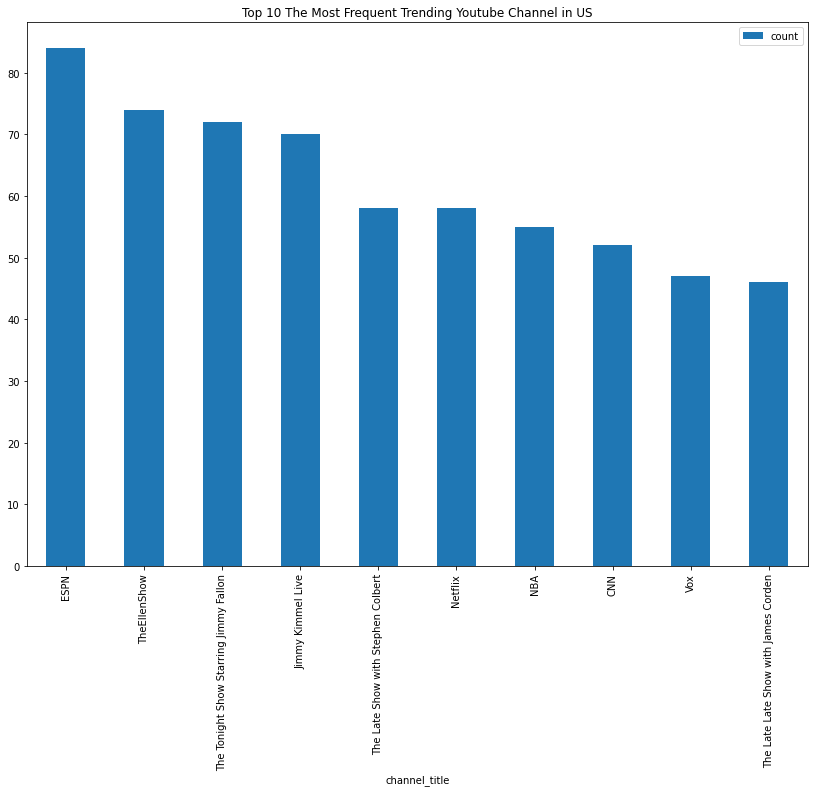

In [ ]:
# Visualization
result_df = df.groupBy("channel_title").count().sort("count", ascending=False)
result_temp = result_df.toPandas()
result_temp.iloc[0:10].plot.bar(x='channel_title',figsize=(14, 10))
plt.title('Top 10 The Most Frequent Trending Youtube Channel in US')

Text(0.5, 1.0, 'Top 10 The Most Liked Per View Video in Youtube US')

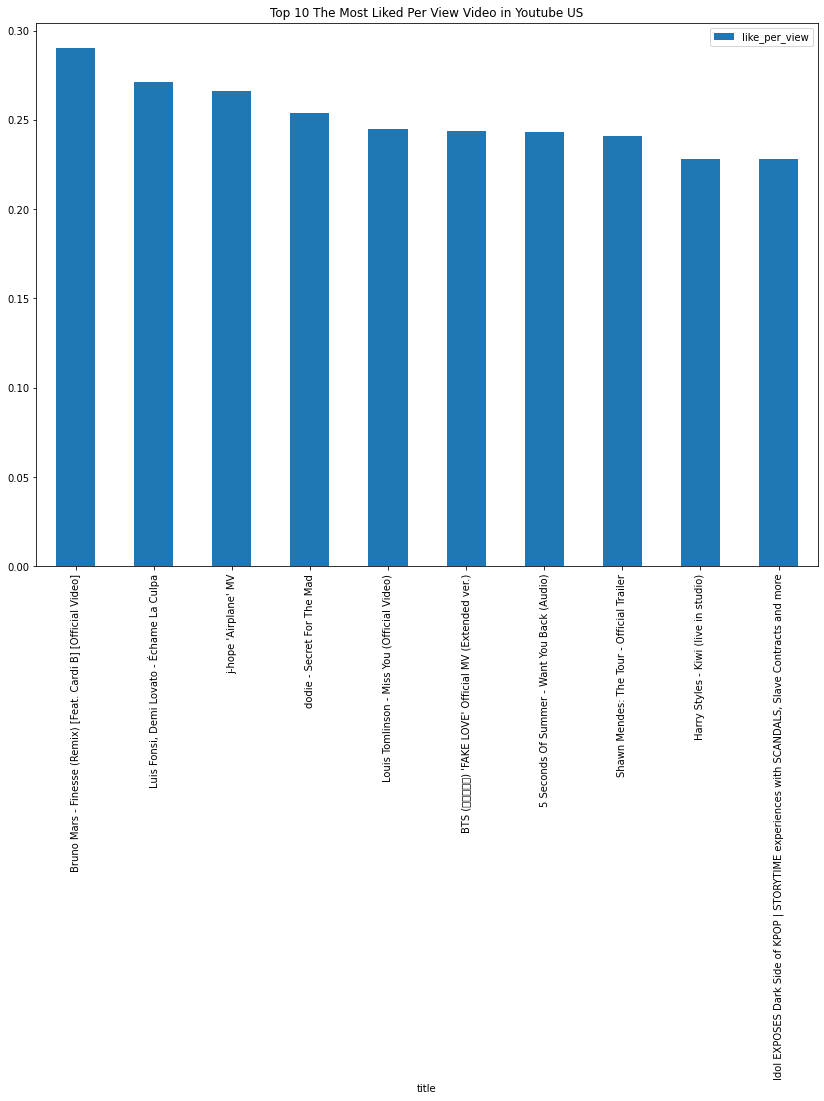

In [ ]:
df_sort_lpv = df.orderBy('like_per_view', ascending=False)
df_lpv_temp = df_sort_lpv.select("title","like_per_view").toPandas()
df_lpv_temp.iloc[0:10].plot.bar(x='title',figsize=(14, 10))
plt.title('Top 10 The Most Liked Per View Video in Youtube US')

Text(0.5, 1.0, 'Top 10 The Most Disliked Per View Video in Youtube US')

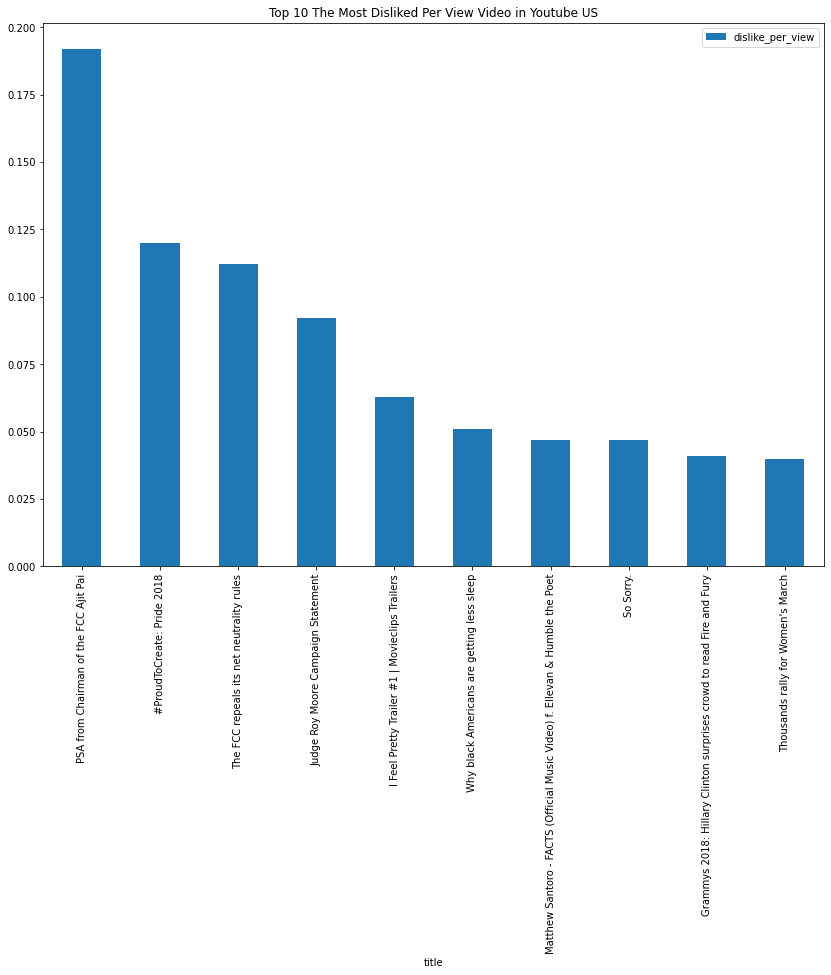

In [ ]:
df_sort_dpv = df.orderBy('dislike_per_view', ascending=False)
df_dpv_temp = df_sort_dpv.select("title","dislike_per_view").toPandas()
df_dpv_temp.iloc[0:10].plot.bar(x='title',figsize=(14, 10))
plt.title('Top 10 The Most Disliked Per View Video in Youtube US')

Text(0.5, 1.0, 'Top 10 The Most Comment Per View Video in Youtube US')

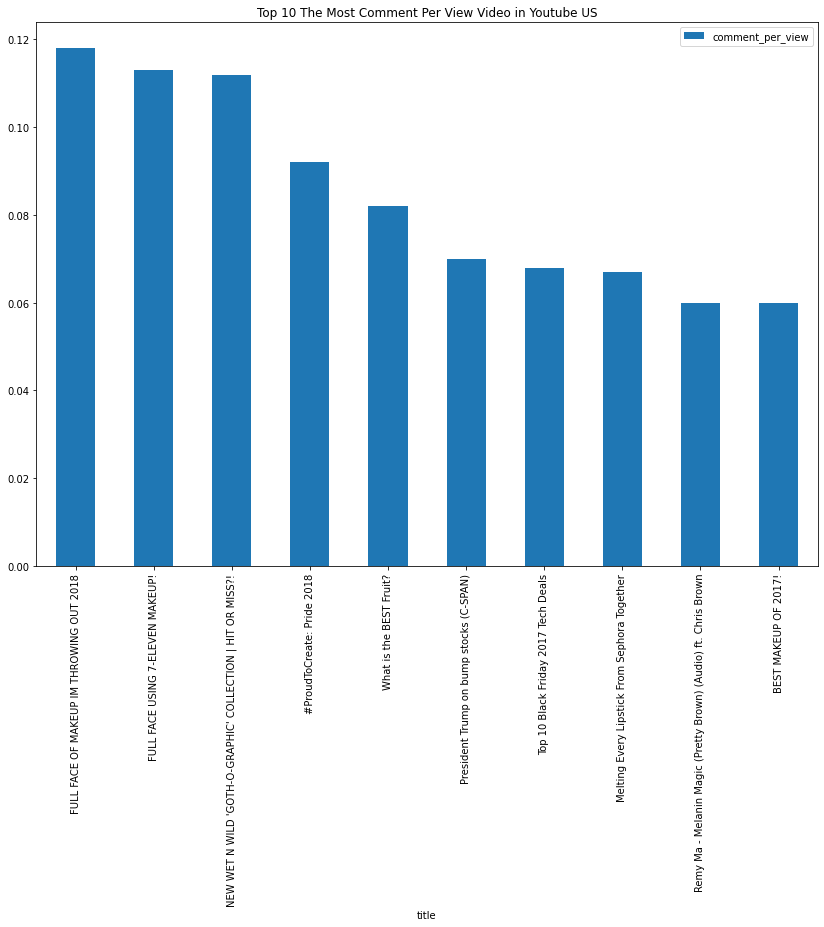

In [ ]:
df_sort_cpv = df.orderBy('comment_per_view', ascending=False)
df_cpv_temp = df_sort_cpv.select("title","comment_per_view").toPandas()
df_cpv_temp.iloc[0:10].plot.bar(x='title',figsize=(14, 10))
plt.title('Top 10 The Most Comment Per View Video in Youtube US')

In [ ]:
group_data = df.groupBy("channel_title")
group_data = group_data.agg({'views':'sum'})
group_data = group_data.withColumnRenamed("sum(views)","sum_views")

Text(0, 0.5, 'Dalam Ratusan Juta')

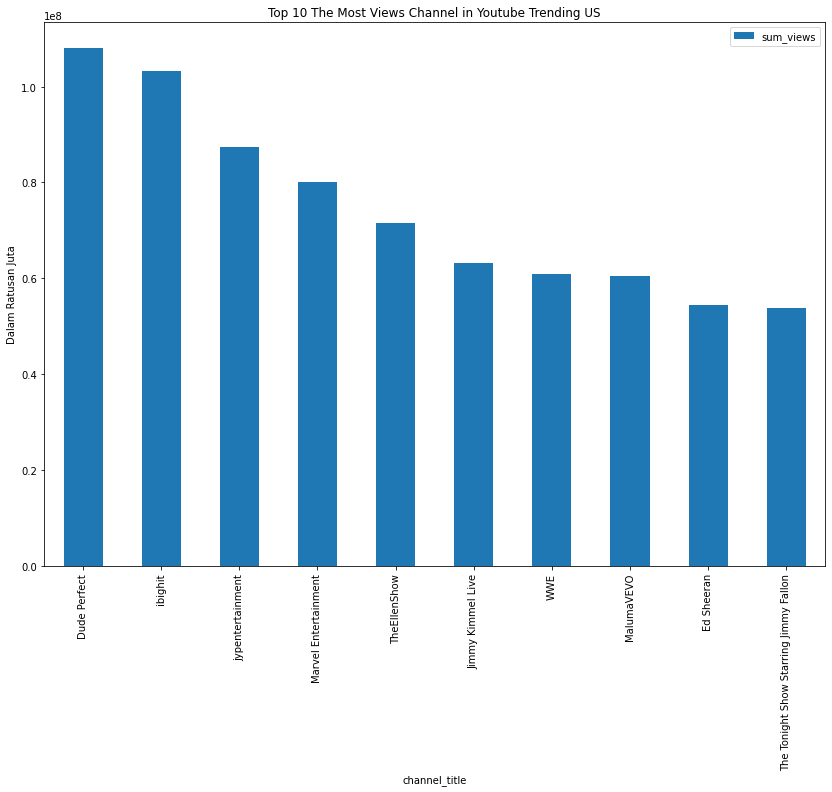

In [ ]:
from pyspark.sql.functions import desc
group_data_sort = group_data.orderBy(desc("sum_views")).toPandas()
group_data_sort.iloc[0:10].plot.bar(x='channel_title',figsize=(14, 10))
plt.title('Top 10 The Most Views Channel in Youtube Trending US')
plt.ylabel('Dalam Ratusan Juta')

Text(0.5, 0, 'Persentase')

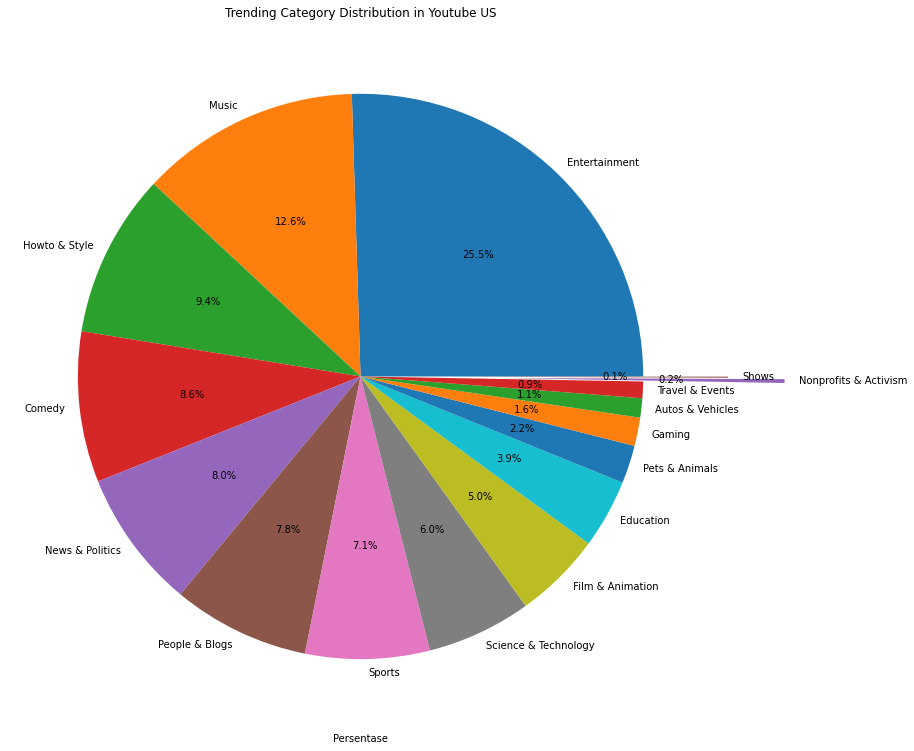

In [ ]:
df_cat = df.groupBy("category").count().sort("count", ascending=False, ignore_index=True).toPandas()
f,ax=plt.subplots(figsize=(15,13))
explode = (0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5,0.3)
plt.pie(df_cat['count'], labels = df_cat['category'], autopct='%1.1f%%', explode = explode, labeldistance=1.05)
ax.set_title('Trending Category Distribution in Youtube US')
ax.set_xlabel('Persentase')